In [2]:
from collections import Counter
from math import prod
import scipy as sp
from scipy import special
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def partitions(n , I=1):
    """Enumerate all the integer parition of n"""
    yield (n,)
    for i in range(I, n//2 + 1):
        for p in partitions(n-i, i):
            yield (i,) + p

def degenerate_partitions(n):
    """Enumerate all the integer parition of n as (i, count, count!)
       (it turns the degeneracy to count)
    """
    for partition in partitions(n):
        #yield [(k, count, sp.special.factorial(count, exact=True)) for k, count in Counter(partition).items()]
        yield [(k, count, prod(range(1, count+1)) ) for k, count in Counter(partition).items()]

def degenerate_partitions_lookup(n):
    """Create a lookup table for all partitions of 1 to n.
    
       For each k \in [1,n], it will create the paritiotns P_k
       such that i_1 + i_2 + i_j = k.
       
       return:
       for each element in P_k,it returns a tuple and a list
       ( \sum_j i_j ,[ (i_1, n_1, n_1!), ..., (i_j, n_j, n_j!)])
        where i_j is the partioned element, n_j is degeneracy and n_j! is
        the degenarcy factorial. 
        The first element of the tuple is the sum of degeneracies
    """
    def partion_to_list(partition):
        partition = list(partition)
        # since element of the parition are (i_j, n_j, n_j!), so, we add all n_j
        degeneracy_sum = sum(map(lambda t: t[1], partition)) 
        return (degeneracy_sum, partition)
    for k in range(1, n+1): 
        yield [partion_to_list(partition) for partition in degenerate_partitions(k)]            
        
        
        
# def degenerate_partitions2(n):
#     """Enumerate all the integer parition of n as (i, count)
#        (it turns the degeneracy to count)
#     """
#     for partition in partitions(n):
#         yield [(k, count) for k, count in Counter(partition).items()]        
        
        
def multinomial(tup):
    """Multinomial coefficients for a tuple of integer"""
    res, i = 1, sum(tup)
    i0 = tup.index(max(tup))
    for a in tup[:i0] + tup[i0+1:]:
        for j in range(1,a+1):
            res *= i
            res //= j
            i -= 1
    return res        


    
for n in range(1,6):
    print(n, list(partitions(n)))
    #print([multinomial(p) for p in partitions(n)])

print()
print()
for n in range(1,6):
    print(n, list(degenerate_partitions(n)))


1 [(1,)]
2 [(2,), (1, 1)]
3 [(3,), (1, 2), (1, 1, 1)]
4 [(4,), (1, 3), (1, 1, 2), (1, 1, 1, 1), (2, 2)]
5 [(5,), (1, 4), (1, 1, 3), (1, 1, 1, 2), (1, 1, 1, 1, 1), (1, 2, 2), (2, 3)]


1 [[(1, 1, 1)]]
2 [[(2, 1, 1)], [(1, 2, 2)]]
3 [[(3, 1, 1)], [(1, 1, 1), (2, 1, 1)], [(1, 3, 6)]]
4 [[(4, 1, 1)], [(1, 1, 1), (3, 1, 1)], [(1, 2, 2), (2, 1, 1)], [(1, 4, 24)], [(2, 2, 2)]]
5 [[(5, 1, 1)], [(1, 1, 1), (4, 1, 1)], [(1, 2, 2), (3, 1, 1)], [(1, 3, 6), (2, 1, 1)], [(1, 5, 120)], [(1, 1, 1), (2, 2, 2)], [(2, 1, 1), (3, 1, 1)]]


In [7]:
list(degenerate_partitions(2))

[[(2, 1, 1)], [(1, 2, 2)]]

In [1119]:
one_houndred_lookup = list(degenerate_partitions_lookup(80))

In [42]:
one_houndred_lookup2 = list(degenerate_partitions_lookup(50))

In [1123]:
import pickle
import bz2
with bz2.BZ2File('lookup_80.pbz2', 'wb') as f:
    pickle.dump(one_houndred_lookup, f)

In [4]:
import pickle
import bz2
with bz2.BZ2File('lookup_80.pbz2', 'rb') as f:
    one_houndred_lookup = pickle.load(f)

In [5]:
def composition(f_0, f_s, g_s, n_max):
    assert len(f_s) >= n_max
    assert len(g_s) >= n_max
    coefs = [f_0]
    for n in range(1, n_max):        
        c = 0
        for partition in degenerate_partitions(n):
            partition = list(partition)            
            # t is (i, count, count!), so, we add all counts
            degeneracy_sum = sum(map(lambda t: t[1], partition))        
            # t is (i, count, count!). Here, we find (g[i]^count)/count!
            g_coef_prod = prod(map(lambda t: (g_s[t[0]-1] ** t[1])/t[2], partition))
            # coefficents \time the derivative f^(n) at g_0
            c += g_coef_prod*f_s[degeneracy_sum-1]
        coefs.append(c)
    return coefs

def composition_fast(f_0, f_s, g_s, lookup, n_max):
    #assert len(f_s) >= len(lookup)
    #assert len(g_s) >= len(lookup)
    coefs = [f_0]
    for P_K in lookup[:n_max]:
        c = sum([ prod(map(lambda t: (g_s[t[0]-1] ** t[1])/t[2], partition))*f_s[degeneracy_sum-1] 
                 for degeneracy_sum, partition in P_K])
        coefs.append(c)
    return coefs

def composition_fast_np(f_0, f_s, g_s, lookup, n_max):
    #assert len(f_s) >= len(lookup)
    #assert len(g_s) >= len(lookup) 
    
    return [f_0] +[
            np.sum(
                [prod(map(lambda t: (g_s[t[0]-1] ** t[1])/t[2], partition))*f_s[degeneracy_sum-1] 
                   for degeneracy_sum, partition in P_K]
                  ) 
                   for P_K in lookup[:n_max]
            ]
 
def create_power_series(coefs):
    max_n = len(coefs)
    def power_series(x):
        return np.sum([ c*(x ** n) for n, c in zip(range(max_n), coefs)])
    return power_series

def create_power_series_np(coefs):
    max_n = len(coefs)
    ns = np.arange(0, len(coefs), 1)[np.newaxis, :]
    def power_series(x):
        return np.einsum('j,ij->i', coefs, np.power(x[:, np.newaxis], ns))
    return power_series

In [27]:
f_0 = 0
f_s = [0,0,6,0,0,0,0,0]
g_s = [1,0,0,0,0,0,0,0]
composition(f_0, f_s, g_s,6)

[0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [6]:
f_0 = 0
f_s = [1,2,3,4]
g_s = [10,20,30,40]
composition(f_0, f_s, g_s,4), composition_fast(f_0, f_s, g_s, one_houndred_lookup, 3)

([0, 10.0, 120.0, 930.0], [0, 10.0, 120.0, 930.0])

In [30]:
f_x = lambda x: x**3 + 2*x**2 - 2
f_1_x = lambda x: 3*x**2 + 4*x
f_2_x = lambda x: 3*2*x + 4
f_3_x = lambda x: 3*2
#g_x = lambda x: 2*x+1
g_x = lambda x: np.sin(x)
g_0 = g_x(0.0)
f_0 = f_x(g_0)
f_s = [f_1_x(g_0), f_2_x(g_0), f_3_x(g_0)] + [0]*100
#g_s = [2, 0, 0, 0] + [0]*20
g_s = [(-1)**(i//2)/sp.special.factorial(i, exact=True) if i%2==1 else 0  for i in range(1, 101)] 
coefs=composition(f_0, f_s, g_s,43)
#coefs=composition_fast_np(f_0, f_s, g_s, one_houndred_lookup, 60)
print(coefs)



[-2.0, 0.0, 2.0, 1.0, -0.6666666666666666, -0.5, 0.08888888888888888, 0.10833333333333334, -0.006349206349206348, -0.013558201058201054, 0.0002821869488536155, 0.0011094576719576717, -8.551119662230774e-06, -6.400813692480358e-05, 1.8793669587320383e-07, 2.743210456504107e-06, -3.1322782645533972e-09, -9.07680099148353e-08, 4.094481391573068e-11, 2.3886318891878983e-09, -4.3099804121821766e-13, -5.118496917146405e-11, 3.731584772452101e-15, 9.104045902383677e-13, -2.7040469365594935e-17, -1.3656068853962333e-14, 1.6640288840366114e-19, 1.7507780582058093e-16, -8.80438562982334e-22, -1.9405175521992355e-18, 4.047993393022225e-24, 1.8779202118057848e-20, -1.6322554004121876e-26, -1.600500180516301e-22, 5.819092336585339e-29, 1.2104623213988835e-24, -1.8473309005032823e-31, -8.178799468911377e-27, 5.255564439554146e-34, 4.966882268569661e-29, -1.347580625526704e-36, -2.725728074215058e-31, 3.130268584266444e-39]


In [31]:
f_est = create_power_series_np(coefs)

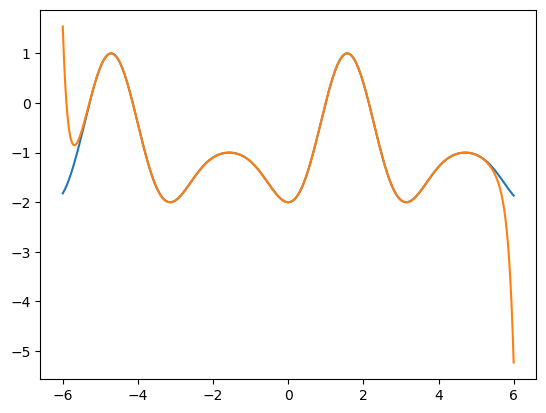

In [34]:
#x_s = np.linspace(-8,8, 400)
x_s = np.linspace(-6,6, 400)
plt.plot(x_s, f_x(g_x(x_s)))
plt.plot(x_s, f_est(x_s))
#plt.plot(x_s, [f_est2(x) for x in x_s])

In [23]:
f_x = lambda x: np.sin(x)
f_1_x = lambda x: np.cos(x)
f_2_x = lambda x: -np.sin(x)
f_3_x = lambda x: -np.cos(x)

g_x = lambda x: x**3 + 2*x**2 - 2
g_0 = g_x(0.0)
f_0 = f_x(g_0)
f_s = [f_1_x(g_0), f_2_x(g_0), f_3_x(g_0), f_x(g_0)]*80

g_s = [0, 2, 1, 0] + [0]*76 
coefs=composition(f_0, f_s, g_s,40)
#coefs=composition_fast_np(f_0, f_s, g_s, one_houndred_lookup, 65)
print(coefs)


[-0.9092974268256817, 0.0, -0.8322936730942848, -0.4161468365471424, 1.8185948536513634, 1.8185948536513634, 1.009511162142364, 0.8322936730942848, -0.19005144800331203, -1.1430387630097185, -1.0202699165715863, -0.5805303666399888, -0.23449217920910437, 0.10376370163780099, 0.27898904777686107, 0.23558903446089352, 0.1254877134460405, 0.03830022652501383, -0.016618193210555, -0.03611964049771851, -0.029130110828553886, -0.014902914912567356, -0.00424167029880204, 0.001293550021287304, 0.002860376442181345, 0.0022492372711202004, 0.0011328234824146308, 0.00033027992486721786, -5.1827051647290655e-05, -0.0001507620973173275, -0.00011881354527214076, -5.9982027493822244e-05, -1.8522010599626354e-05, 5.915643362717559e-07, 5.569077766286206e-06, 4.549829715702192e-06, 2.336158559984919e-06, 7.701283769728093e-07, 4.967491793348216e-08, -1.4815209369926988e-07]


In [24]:
f_est = create_power_series_np(coefs)

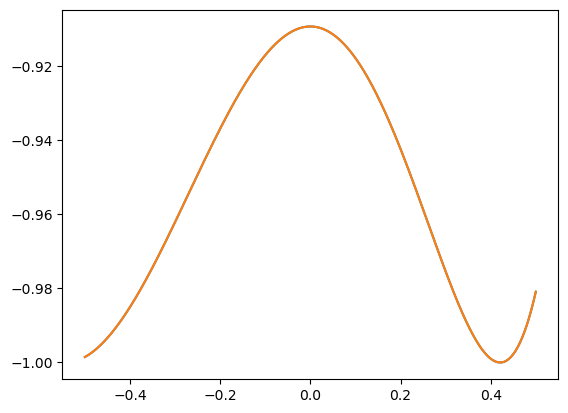

In [25]:
#x_s = np.linspace(-1.7, 1.7, 400)
x_s = np.linspace(-.5, .5, 400)
plt.plot(x_s, f_x(g_x(x_s)))
plt.plot(x_s, f_est(x_s))

# Solve the
### <h2><center>$\frac{dx}{dt} + \mu x - b = f(x).$</center></h2>
### When
<h3><center>$x(t) = \sum_{i \ge 0} a_i t^i$</center></h3>

### The solution will be

<h3><center>$i = 0, \qquad a_1 = b-\mu a_0  + V C_0(a_0)$</center></h3>
<h3><center>$i \ge 1, \qquad a_{i+1} = \frac{1}{i+1}( -\mu a_i + V C_i(a_0 ))$</center></h3>


### for

<h3><center>$ C_i(a_0 ) = \sum_{P_i} \frac{a_1^{n_1} \dots a_i^{n_i}}{n_1! \dots n_i!} f^{n_1+\dots+n_i}(a_0),$</center></h3>
and $ P_i$ is the set of all partitions of $i$.

In [287]:
def C_i(a_s, f_s):
    i = len(a_s)
    c = 0
    for partition in degenerate_partitions(i):
        partition = list(partition)            
        # t is (i, count, count!), so, we add all counts
        degeneracy_sum = sum(map(lambda t: t[1], partition))        
        # t is (i, count, count!). Here, we find (g[i]^count)/count!
        a_coef_prod = prod(map(lambda t: (a_s[t[0]-1] ** t[1])/t[2], partition))
        # coefficents \time the derivative f^(n) at g_0
        c += a_coef_prod*f_s[degeneracy_sum-1]
    return c

def C_i_fast(a_s, f_s, i, lookup):    
    coefs = [f_0]
    P_K = lookup[i-1]    
    return sum([ prod(map(lambda t: (a_s[t[0]-1] ** t[1])/t[2], partition))*f_s[degeneracy_sum-1] 
                 for degeneracy_sum, partition in P_K])

def X_t_coefs(f_s, a_0, mu, b, i_max, V=1.0):
    c_0 = f_s[0]    
    a_s = [b - mu*a_0 + V * c_0]
    for i in range(1, i_max+1):
        c_i = C_i(a_s, f_s[1:])
        a_i_1 = (1/(i+1))*(- mu*a_s[-1] + V * c_i)
        a_s.append(a_i_1)
    return [a_0] + a_s

def X_t_coefs_fast(f_s, a_0, mu, b, i_max, lookup, V=1.0):
    c_0 = f_s[0]    
    a_s = [b - mu*a_0 + V * c_0]
    for i in range(1, i_max+1):
        c_i = C_i_fast(a_s, f_s[1:], i, lookup)
        a_i_1 = (1/(i+1))*(- mu*a_s[-1] + V * c_i)
        a_s.append(a_i_1)
    return [a_0] + a_s

In [1216]:
f_x = lambda x: x**3 #+ x**2 - x - 1
f_1_x = lambda x: 3*x**2 #+ 2*x -1
f_2_x = lambda x: 3*2*x #+ 2
f_3_x = lambda x: 3*2

a_0 = 0
f_s = [f_x(a_0), f_1_x(a_0), f_2_x(a_0), f_3_x(a_0)] + [0]*100
b=.5
mu=2
coefs=X_t_coefs_fast(f_s, a_0, mu, b, 70, one_houndred_lookup)

def dxdt(x, t):
    return b - mu*x + f_x(x)

In [1217]:
f_est = create_power_series_np(coefs[:-3])
f_est2 = create_power_series_np(coefs)

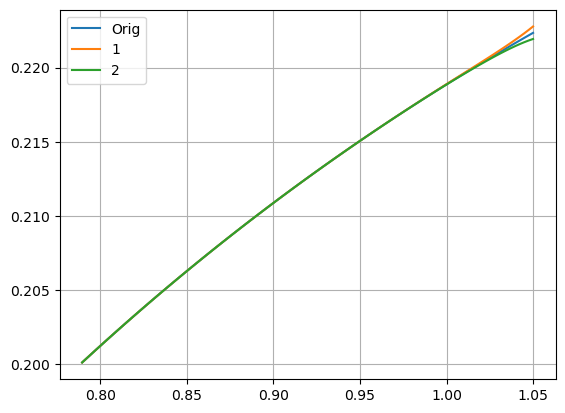

In [1226]:
from scipy.integrate import odeint

x_s = np.linspace(0.0,1.05, 400)

start=300
plt.plot(x_s[start:], odeint(dxdt, a_0, x_s)[start:] ,label="Orig")
plt.plot(x_s[start:], f_est(x_s)[start:],label="1")
plt.plot(x_s[start:], f_est2(x_s)[start:],label="2");plt.grid();plt.legend()

In [841]:
f_x = lambda x: np.sin(x)
f_1_x = lambda x: np.cos(x)
f_2_x = lambda x: -np.sin(x)
f_3_x = lambda x: -np.cos(x)

a_0 = 0
f_s = [f_x(a_0), f_1_x(a_0), f_2_x(a_0), f_3_x(a_0)] + [0]*100
b=.5
mu=2
coefs=X_t_coefs_fast(f_s, a_0, mu, b, 70, one_houndred_lookup)

def dxdt(x, t):
    return b - mu*x + f_x(x)

In [842]:
f_est = create_power_series_np(coefs[:-3])
f_est2 = create_power_series_np(coefs)

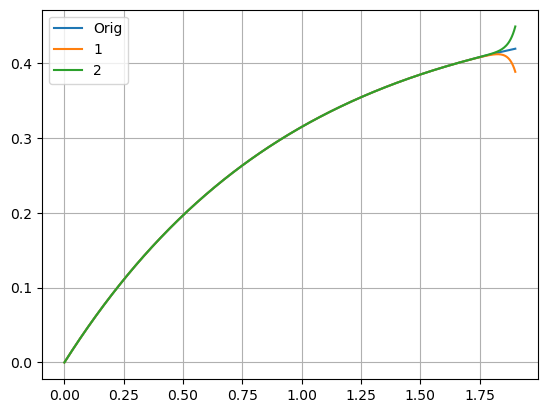

In [853]:
from scipy.integrate import odeint

x_s = np.linspace(0.0, 1.9, 400)

start=0
plt.plot(x_s[start:], odeint(dxdt, a_0, x_s)[start:] ,label="Orig")
plt.plot(x_s[start:], f_est(x_s)[start:],label="1")
plt.plot(x_s[start:], f_est2(x_s)[start:],label="2");plt.grid();plt.legend()

# Sewing

In [1018]:
f_x = lambda x: np.sin(x)
f_1_x = lambda x: np.cos(x)
f_2_x = lambda x: -np.sin(x)
f_3_x = lambda x: -np.cos(x)

f_ests = []
a_0_s = []
a_0 = 0
a_0_s.append(a_0)
f_s = [f_x(a_0), f_1_x(a_0), f_2_x(a_0), f_3_x(a_0)] + [0]*100
b=.5
mu=2
shift = 0.1
max_iter = 100
for i in range(max_iter):
    
    coefs=X_t_coefs_fast(f_s, a_0, mu, b, 30, one_houndred_lookup)

    def dxdt(x, t):
        return b - mu*x + f_x(x)

    f_est = create_power_series_np(coefs)
    
    f_ests.append(f_est)
    
    a_0 = f_est(np.array([0.0, shift]))[-1]
    a_0_s.append(a_0)
    f_s = [f_x(a_0), f_1_x(a_0), f_2_x(a_0), f_3_x(a_0)] + [0]*100


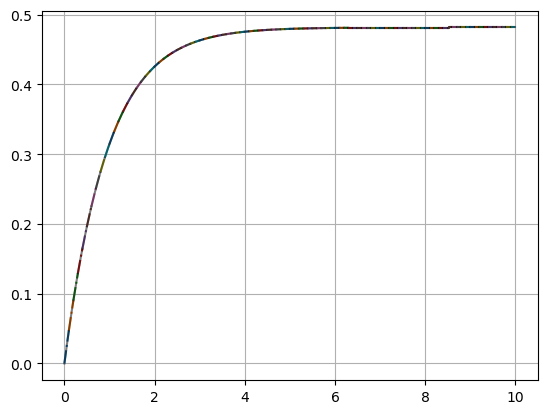

In [1019]:
from scipy.integrate import odeint


x_s_start = np.linspace(0.0, shift, 400)
origi_a_0=a_0_s[0]
for i in range(max_iter):

    x_s = np.linspace(i*shift, (i+1)*shift, 400)
    f_est = f_ests[i]
    
    numeric_x_s = odeint(dxdt, origi_a_0, x_s_start)
    origi_a_0 = numeric_x_s[-1]
    plt.plot(x_s, numeric_x_s, '-.' ,label="Orig")
    plt.plot(x_s, f_est(x_s_start), alpha=.5, color='black');

plt.grid();

#

<h3><center>$-\frac{d^n H(x)}{dx^n} = \frac{d^n h(x)}{dx^n} = \frac{d^n}{dx^n} \frac{1}{1 + (\frac{x}{k})^{\alpha}}$</center></h3>
<h3><center>$= \begin{cases}
                 0,&  n/\alpha - \lfloor n/\alpha \rfloor \ne 0\\
                 (-1)^{n/\alpha} \frac{n!}{k^n},              & \text{otherwise}
              \end{cases}$</center></h3>

In [288]:
def binomial_coef(n):
    """Finds all the Binomial coefiecents of n."""
    val = 1
    yield val
    if n == 1:
        yield val
        return
    for i in range(n):
        val *= (n-i)
        val //= (i+1)
        yield val
        
def mul_derivatives(n, f1s, f2s):
    """Finds the nth derivatives of g(x) = f1(x)f2(x)
    
       args:
    
       n:   order of the derivatives.
       f1s: An array of previous derivatives of the first function
            (f1, f1', f1'', ..., f1^(n-1)).
       f2s: An array of previous derivatives of the second function
            (f2, f2', f2'', ..., f2^(n-1)).
    """
    assert n+1 == len(f1s)
    assert n+1 == len(f2s)
    
    return np.sum([(c * v1) * v2 for c, v1, v2 in zip(binomial_coef(n), f1s, f2s[::-1]) ])
    
    
    
def Hill_derivatives(alpha, k, n, x0):    
        
    def H(x):
        return x**alpha / (x**alpha + k**alpha)
    
    def h(x):        
        return k**alpha / (x**alpha + k**alpha)
    
    if x0 == 0:
        hs = [h(x0)]
        Hs = [H(x0)]
        hsHs = [h(x0) * H(x0)]
        for i in range(1, n):
            if i%alpha != 0:
                hs += [0]
            else:
                hs += [((-1)**(i//alpha))*prod(range(1,i+1))/(k**i)]
            Hs += [-hs[-1]]        
            hsHs += [hs[-1] * Hs[-1]]
        return (hs, Hs, hsHs)
        
    def f_der(x, order):
        if x == 0:
            return 0.0
        
        ret = ((-1)**order) * alpha / (x ** (1+order))
        ret *= np.prod(range(1, order+1))
        return ret
    
    hs = [h(x0)]
    Hs = [H(x0)]
    fs = [f_der(x0, 0)]
    hsHs = [h(x0) * H(x0)]
    
    Hs += [fs[0] * hsHs[0]]
    hs += [-Hs[-1]]    
    hsHs += [mul_derivatives(1, hs, Hs)]
    fs += [f_der(x0, 1)]
                
    for i in range(2, n):  
        Hs += [mul_derivatives(i-1, fs, hsHs)]
        hs += [-Hs[-1]]        
        
        hsHs += [mul_derivatives(i, hs, Hs)]
        fs += [f_der(x0, i)]
        
        
        
    return (hs, Hs, hsHs)
        
    

In [289]:
hs, Hs, hsHs = Hill_derivatives(alpha=1, k=1, n=20, x0=0)
hs2, Hs, hsHs = Hill_derivatives(alpha=1, k=1, n=20, x0=1e-10)
list(zip(hs, hs2))

[(1.0, 0.9999999999),
 (-1.0, -0.9999999997999999),
 (2.0, 2.0),
 (-6.0, -32768.0),
 (24.0, -0.0),
 (-120.0, -3.8685626227668134e+25),
 (720.0, -2.658455991569832e+36),
 (-5040.0, -0.0),
 (40320.0, -6.572026697887683e+57),
 (-362880.0, -0.0),
 (3628800.0, 1.1857109937901178e+80),
 (-39916800.0, -8.148143905337944e+90),
 (479001600.0, -5.599361855444511e+101),
 (-6227020800.0, -0.0),
 (87178291200.0, -2.1153791001287955e+124),
 (-1307674368000.0, 1.4536774485912138e+135),
 (20922789888000.0, -1.4764567279765178e+146),
 (-355687428096000.0, -5.491838128104488e+157),
 (6402373705728000.0, -1.5095849699286165e+169),
 (-1.21645100408832e+17, 1.0373788922202482e+180)]

In [411]:
b=1
mu=.001
x0 = 0.0
n_max = 28
alpha = 4
k=0.1
V=1
hs, Hs, hsHs = Hill_derivatives(alpha, k, n_max, x0)

coefs=X_t_coefs_fast(hs, x0, mu, b, n_max-1, one_houndred_lookup, V)

def H(x):
    if x == 0.0:
        return 0.0
    return 1.0 / (1.0 + (k/x)**alpha)

def h(x):        
    return 1.0 / (1.0 + (x/k)**alpha)

def dxdt(x, t):
    return b - mu*x + V*h(x)

X_est = create_power_series_np(coefs)

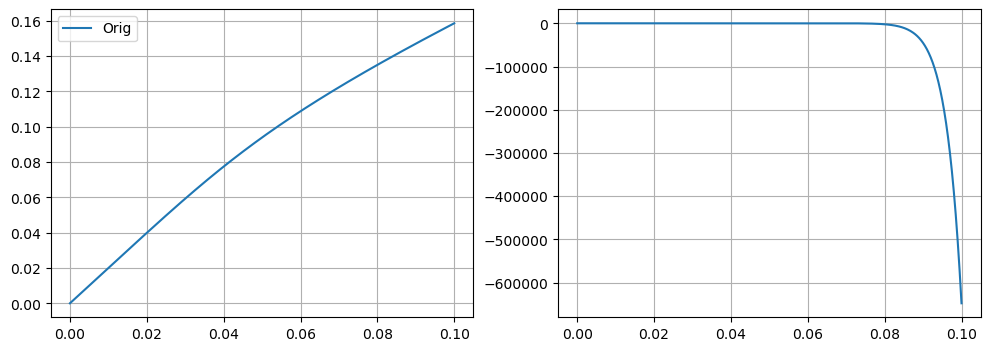

In [412]:
from scipy.integrate import odeint

t_s = np.linspace(0.0, .1, 400)

#p = np.poly1d(np.polyfit(t_s, odeint(dxdt, x0, t_s), 14).squeeze())
start=0
_ = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t_s[start:], odeint(dxdt, x0, t_s)[start:, 0] ,label="Orig")
#plt.plot(t_s[start:], X_est(t_s)[start:],label="1")
#plt.plot(t_s[start:], 
#         p(t_s[start:]), label="Fit")
plt.grid();plt.legend();
plt.subplot(122)
plt.plot(t_s[start:], odeint(dxdt, x0, t_s)[start:, 0]-X_est(t_s)[start:])
plt.grid();

In [405]:
coefs

[0.0,
 1.01,
 -0.00505,
 1.6833333333333334e-05,
 -4.2083333333333336e-08,
 -0.20812080191583335,
 0.0038155480365263885,
 -3.7659954647418645e-05,
 2.6386744539260664e-07,
 0.21561833045987755,
 -0.0074060727532433415,
 0.00013406627124808564,
 -1.6966102313882991e-06,
 -0.3127392775663053,
 0.015868814513937745,
 -0.0004184204900694467,
 7.622061916503663e-06,
 0.5276641660305399,
 -0.03549113057652258,
 0.0012299563142187326,
 -2.9229449606370767e-05,
 -0.9705801838673084,
 0.08137119234461794,
 -0.003495498656728948,
 0.00010245963968227449,
 1.887951183029652,
 -0.18963610740000264,
 0.0097224132156982,
 -0.00033892649830427623]

In [223]:
coefs2 = [0, 1, -1/(2*k), 3/(3*2*k**2), -5/(4*2*k**3), 35/(5*8*k**4), -63/(6*8*k**5),
         231/(7*16*k**6), -429/(8*16*k**7), 6435/(9*128*k**8),
         -12155/(10*128*k**9), 46189/(11*256*k**10)]

[(a,b) for a,b in zip(coefs,coefs2)]

[(0.0, 0),
 (1.0, 1),
 (-1.0, -1.0),
 (2.0, 2.0),
 (-5.0, -5.0),
 (14.0, 14.0),
 (-42.0, -42.0),
 (132.0, 132.0),
 (-429.0, -429.0),
 (1430.0, 1430.0),
 (-4862.0, -4862.0),
 (16796.0, 16796.0)]

In [1188]:
b=0.01
mu=2
n_max = 41
alpha = 1
k=1.0

def H(x):
    if x == 0.0:
        return 0.0
    return 1.0 / (1.0 + (k/x)**alpha)

def h(x):        
    return 1.0 / (1.0 + (x/k)**alpha)

x_ests = []

x0_s = []
x0 = 0.0
x0_s.append(x0)

hs, Hs, hsHs = Hill_derivatives(alpha, k, n_max, x0)

shift = .1
max_iter = 100
for i in range(max_iter):
    
    coefs=X_t_coefs_fast(Hs, x0, mu, b, 20, one_houndred_lookup)

    def dxdt(x, t):
        return b - mu*x + H(x)

    x_est = create_power_series_np(coefs)
    
    x_ests.append(x_est)
    
    x0 = x_est(np.array([0.0, shift]))[-1]
    x0_s.append(x0)
    hs, Hs, hsHs = Hill_derivatives(alpha, k, n_max, x0)


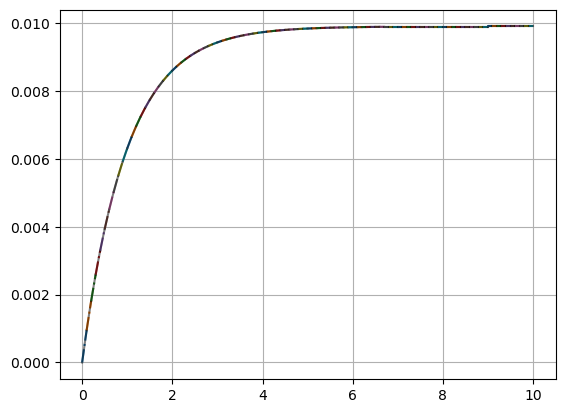

In [1189]:
from scipy.integrate import odeint

t_s_start = np.linspace(0.0, shift, 400)
origi_x0=x0_s[0]
for i in range(max_iter):

    t_s = np.linspace(i*shift, (i+1)*shift, 400)
    x_est = x_ests[i]
    
    numeric_x_s = odeint(dxdt, origi_x0, t_s_start)
    origi_x0 = numeric_x_s[-1]
    
    plt.plot(t_s, numeric_x_s , '-.' ,label="Orig")
    plt.plot(t_s, x_est(t_s_start), alpha=.5, color='black');

plt.grid();

In [198]:
x0 = 0.0
n_max = 11
alpha = 1
k=1.0
hs, Hs, hsHs = Hill_derivatives(alpha, k, n_max, x0)

def H(x):   
    return x**alpha / (x**alpha + k**alpha)

In [199]:
Hs = np.array(Hs)[::-1]

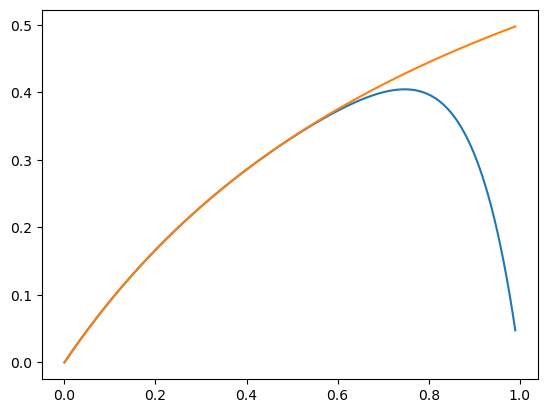

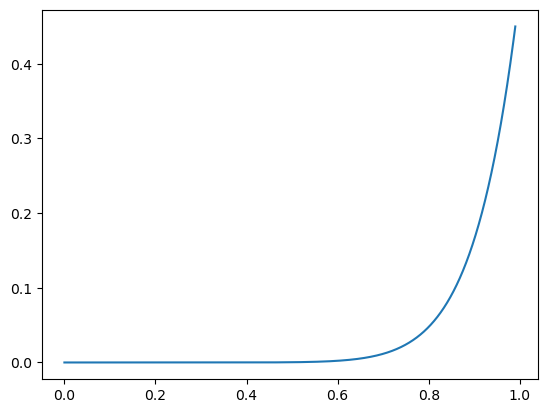

In [200]:
t_s = np.linspace(0.0, .99, 4000)

#coefs2 = np.polyfit(t_s, H(t_s), n_max).squeeze()
p = np.poly1d([-1, 1]*(n_max//2) + [0])
plt.plot(t_s, p(t_s))
plt.plot(t_s, H(t_s));plt.show()
plt.plot(t_s,H(t_s)-p(t_s))

In [110]:
[(a,b) for a,b in zip(Hs,reversed(coefs2))]

[(0.0, 0.00496736798045848),
 (1.0, 0.9247553723090973),
 (-2.0, -0.6910333766145049),
 (6.0, 0.3663421491454555),
 (-24.0, -0.13048261760554913),
 (120.0, 0.030543984002104084),
 (-720.0, -0.0045640790983676825),
 (5040.0, 0.0004019778241771877),
 (-40320.0, -1.5468548205063536e-05),
 (362880.0, -3.2026901781431273e-07)]

In [139]:
H(t_s),p(t_s)

(array([0.        , 0.00249439, 0.00497636, ..., 0.90904956, 0.90907024,
        0.90909091]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [141]:
Hs/Hs

/tmp/ipykernel_51311/1814328205.py:1: RuntimeWarning: invalid value encountered in divide
  Hs/Hs


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., nan])